In [ ]:
pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19535 sha256=02e65498e6cce70430810d9ac78dee6d4945f62a2690e7b379cfb9c6d44ec5d2
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [ ]:
import voxelmorph as vxm

In [ ]:
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5

--2023-11-28 14:17:43--  https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323288 (1.3M)
Saving to: ‘vxm_dense_brain_T1_3D_mse.h5’

vxm_dense_brain_T1_ 100%[===================>]   1.26M  4.44MB/s    in 0.3s    

2023-11-28 14:17:43 (4.44 MB/s) - ‘vxm_dense_brain_T1_3D_mse.h5’ saved [1323288/1323288]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import neurite as ne

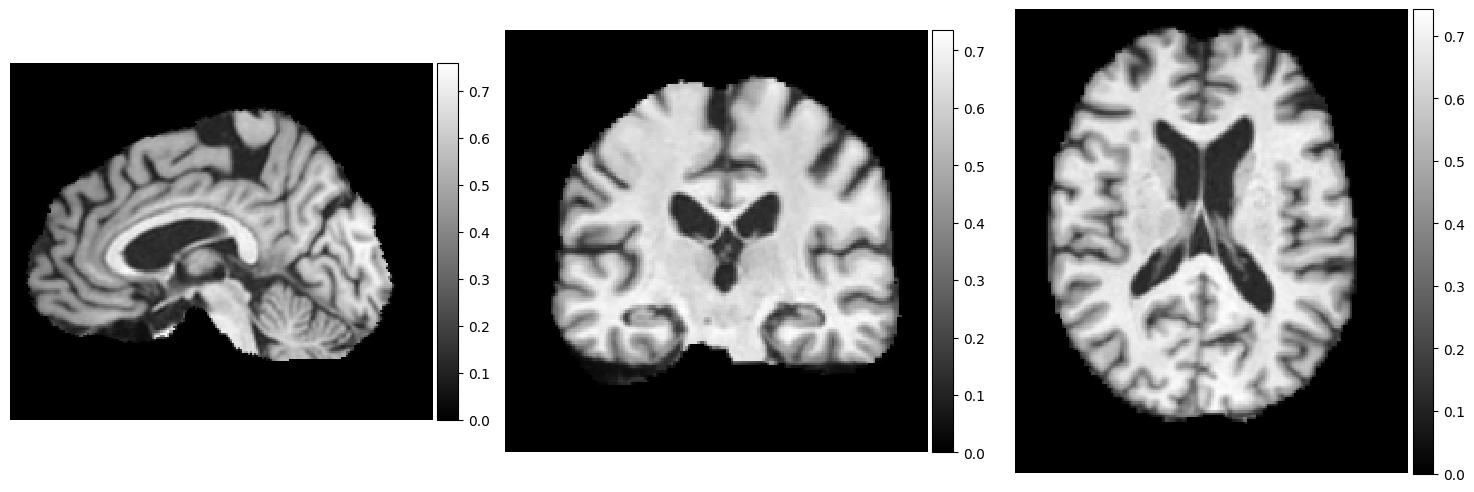

In [ ]:
ruta = '/content/drive/MyDrive/pruebasTFG/002_S_0295_ADNI1_MPRAGE_N3-NoSkull.nii'

moving = nib.load(ruta).get_fdata()
moving = (moving - np.min(moving)) / (np.max(moving) - np.min(moving))

vol_shape = (176, 208, 176)

mid_slices_moving = [np.take(moving, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)
mid_slices_moving[0] = np.transpose(mid_slices_moving[0], (1, 0))
mid_slices_moving[0] = np.rot90(mid_slices_moving[0], -1)
mid_slices_moving[0] = np.rot90(mid_slices_moving[0], -1)
mid_slices_moving[2] = np.flipud(mid_slices_moving[2])

ne.plot.slices(mid_slices_moving, cmaps=['gray'], do_colorbars=True);

moving = moving[0:176,0:208,0:176]
moving = moving[..., np.newaxis]
moving = moving[np.newaxis, ...]

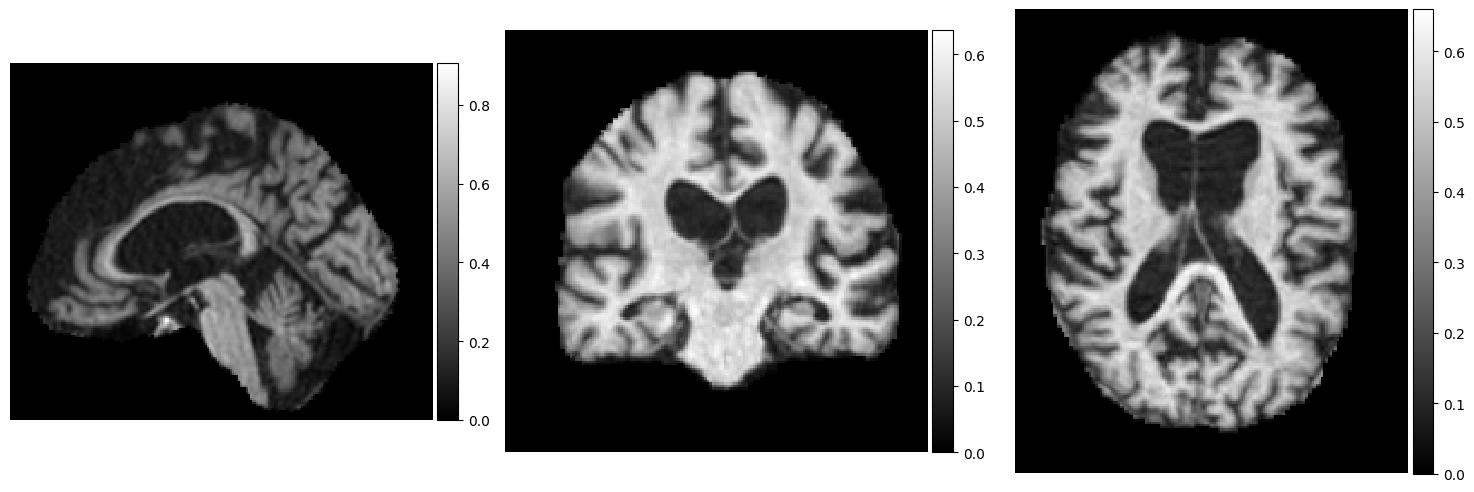

In [ ]:
ruta = '/content/drive/MyDrive/pruebasTFG/002_S_0619_ADNI1_MPRAGE_N3-NoSkull.nii'

fixed = nib.load(ruta).get_fdata()
fixed = (fixed - np.min(fixed)) / (np.max(fixed) - np.min(fixed))

mid_slices_fixed = [np.take(fixed, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)
mid_slices_fixed[0] = np.transpose(mid_slices_fixed[0], (1, 0))
mid_slices_fixed[0] = np.rot90(mid_slices_fixed[0], -1)
mid_slices_fixed[0] = np.rot90(mid_slices_fixed[0], -1)
mid_slices_fixed[2] = np.flipud(mid_slices_fixed[2])

ne.plot.slices(mid_slices_fixed, cmaps=['gray'], do_colorbars=True);

fixed = fixed[0:176,0:208,0:176]
fixed = fixed[..., np.newaxis]
fixed = fixed[np.newaxis, ...]

In [ ]:
inshape = fixed.shape[1:-1]
nb_feats = fixed.shape[-1]

print(inshape)
print(nb_feats)

gpu = 0
device, nb_devices = vxm.tf.utils.setup_device(gpu)

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load('vxm_dense_brain_T1_3D_mse.h5', **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

(176, 208, 176)
1


/usr/local/lib/python3.10/dist-packages/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
/usr/local/lib/python3.10/dist-packages/voxelmorph/tf/networks.py:129: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


1/1 [==============================] - 1s 550ms/step


In [ ]:
print(moved.shape)
moved1 = moved.squeeze()
print(warp.shape)
warp1 = warp.squeeze()

(1, 176, 208, 176, 1)
(1, 176, 208, 176, 3)


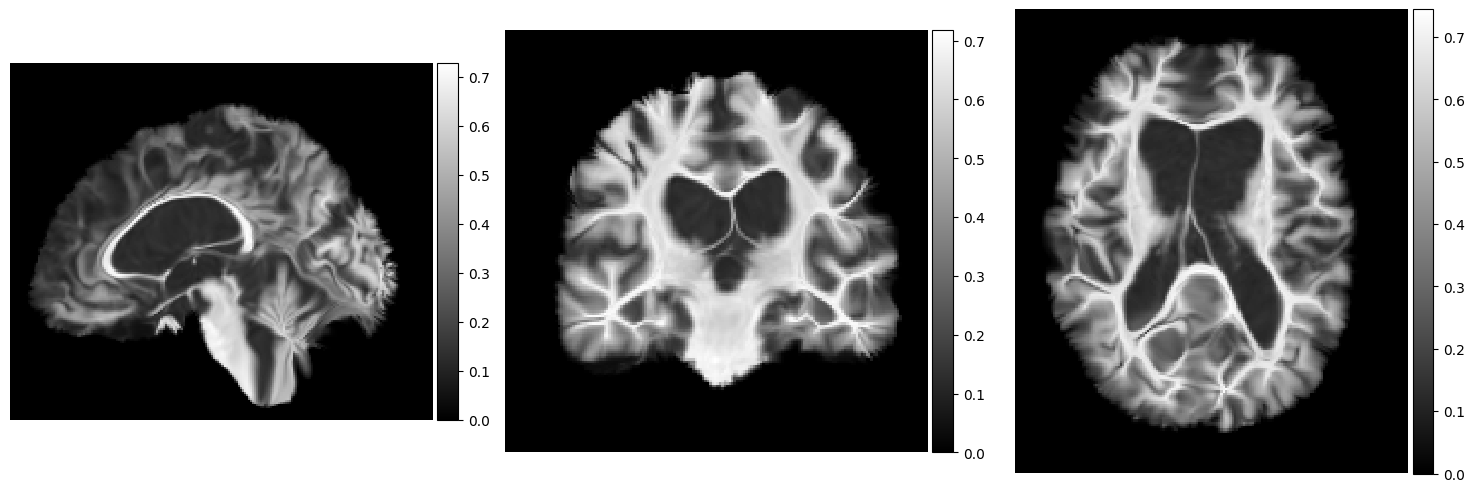

In [ ]:
mid_slices_moved1 = [np.take(moved1, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_moved1[1] = np.rot90(mid_slices_moved1[1], 1)
mid_slices_moved1[2] = np.rot90(mid_slices_moved1[2], -1)
mid_slices_moved1[0] = np.transpose(mid_slices_moved1[0], (1, 0))
mid_slices_moved1[0] = np.rot90(mid_slices_moved1[0], -1)
mid_slices_moved1[0] = np.rot90(mid_slices_moved1[0], -1)
mid_slices_moved1[2] = np.flipud(mid_slices_moved1[2])

ne.plot.slices(mid_slices_moved1, cmaps=['gray'], do_colorbars=True);

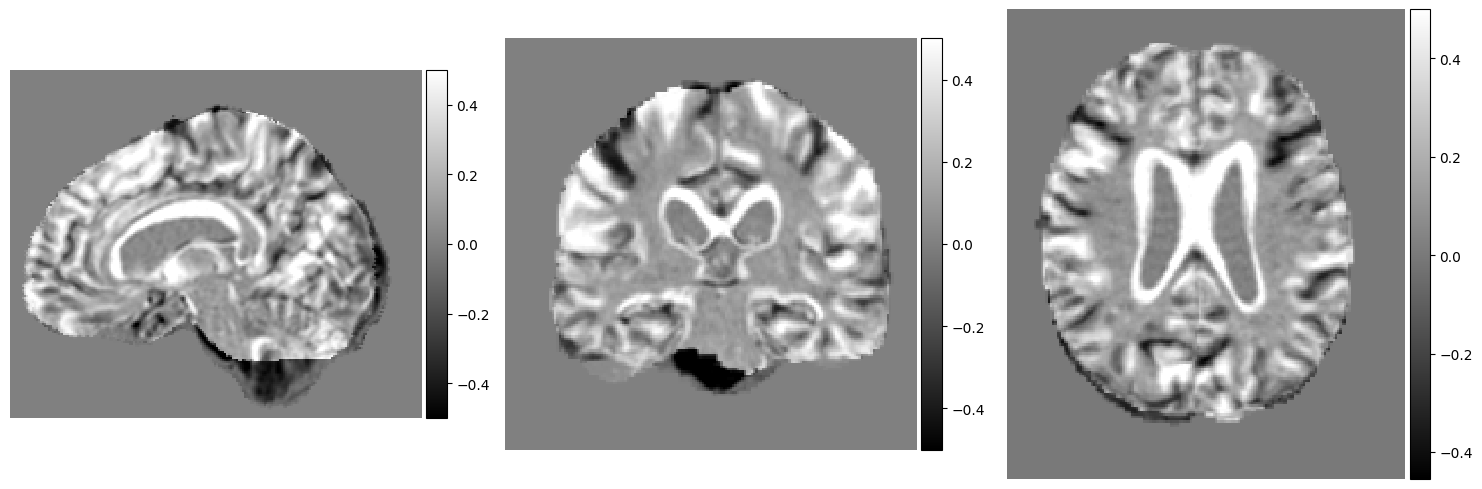

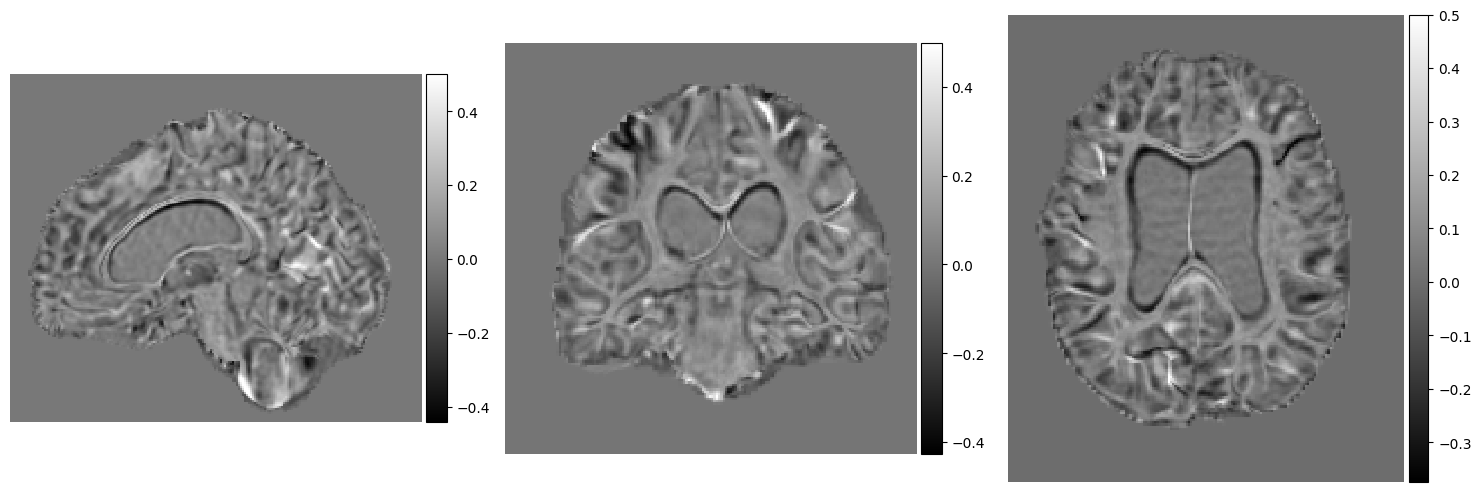

In [ ]:
clim = 0.5
img = moving - fixed

img1 = img[0, 100, :, :,0]
img2 = img[0, :, 100, :,0]
img3 = img[0, :, :, 100,0]

img2 = np.rot90(img2, 1)
img3 = np.rot90(img3, -1)
img1 = np.transpose(img1, (1, 0))
img1 = np.rot90(img1, -1)
img1 = np.rot90(img1, -1)
img3 = np.flipud(img3)

images = [img1, img2, img3]

for i in range(len(images)):
    images[i] = np.clip(images[i], -clim, clim)

# visualize
ne.plot.slices(images, cmaps=['gray'], do_colorbars=True);

img = moved - fixed

img1 = img[0, 100, :, :,0]
img2 = img[0, :, 100, :,0]
img3 = img[0, :, :, 100,0]

img2 = np.rot90(img2, 1)
img3 = np.rot90(img3, -1)
img1 = np.transpose(img1, (1, 0))
img1 = np.rot90(img1, -1)
img1 = np.rot90(img1, -1)
img3 = np.flipud(img3)

images = [img1, img2, img3]

for i in range(len(images)):
    images[i] = np.clip(images[i], -clim, clim)

# visualize
ne.plot.slices(images, cmaps=['gray'], do_colorbars=True);

In [ ]:
import scipy.io as sio
sio.savemat('/content/drive/MyDrive/pruebasTFG/warp_voxelmorph.mat', {'warp_voxelmorph': warp1})

In [ ]:
import scipy.io as sio
sio.savemat('/content/drive/MyDrive/pruebasTFG/warped_voxelmorph.mat', {'warped_voxelmorph': moved1})